## Implementation of the paper "Understanding deep image representations by inverting them" by Mahendran et.al.

While implementing this paper, I used the pretrained VGG16 architecture. The concepts for visualization in the paper are then applied to the pretrained model.

In [76]:
!mkdir sample_images

mkdir: cannot create directory ‘sample_images’: File exists


In [0]:
import os
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf

from urllib.parse import urlparse

tf.enable_eager_execution()

## Download and Preprocess data

This section downloads some sample images used to train ImageNet and preprocesses them. The following steps are applied:

1) The images are resized to (224, 224, 3)

2) The images are collected into a numpy array and transformed to a tensorflow dataset.

3) Each of the image in the dataset is normalized between -1 and 1

In [139]:
sample_image_uris = [
    "http://static.flickr.com/1263/1015124362_008900fa88.jpg",
    "http://farm1.static.flickr.com/1/471345_f090f25d64.jpg",
    "http://farm1.static.flickr.com/9/14720420_8830007ef2.jpg",
    "http://farm3.static.flickr.com/2703/4076139910_4258f63075.jpg",
]

# Downlaod and write some sample images. These are some sample images from the Imagenet dataset
for image_url in sample_image_uris:
    image_name = urlparse(image_url).path.split('/')[-1]
    image_write_path = f'{os.getcwd()}/sample_images/{image_name}'
    print(f'Downloading image {image_name} to {image_write_path}')
    response = requests.get(image_url)
    if response.status_code == 200:
    #     Write the image data to the file
        with open(image_write_path, 'wb') as writer:
            writer.write(response.content)

In [0]:
images = []
resize_dim = 224
train_dataset = np.zeros(shape=(len(sample_image_uris), resize_dim, resize_dim, 3), dtype=np.int)
idx = 0
for file in os.listdir('sample_images'):
    img = cv2.imread(f'sample_images/{file}')
    img = cv2.resize(img, (resize_dim, resize_dim))
    train_dataset[idx, :] = img
    idx = idx + 1

In [0]:
# A utility method to display a batch of images
def display_images(image_batch):
    batch_size = image_batch.shape[0]
    if batch_size == 1:
        plt.imshow(image_batch[0,:])
        plt.show()
        return

    grid_size = math.ceil(math.sqrt(batch_size))

    fig, axis = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    counter = 0
    for i in range(grid_size):
        for j in range(grid_size):
            if counter >= batch_size:
                break
            axis[i, j].imshow(image_batch[counter, :])
            axis[i, j].set_xticks([])
            axis[i, j].set_yticks([])
            counter = counter + 1
    plt.show()

In [0]:
def normalize_func(images):
    images = tf.cast(images, tf.float32)
    images = (images - 127.5) / 127.5
    return images

In [0]:
# Batch the dataset
train = tf.data.Dataset.from_tensor_slices(train_dataset).batch(1)
normalized_train = train.map(normalize_func)

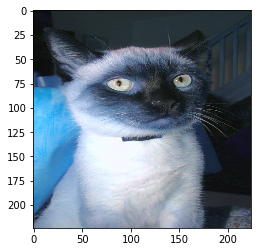

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


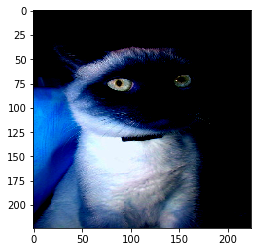

In [146]:
sample_batch = next(iter(train))
normalized_batch = next(iter(normalized_train))

# Display the normal and the standardized images for sanity checking
display_images(sample_batch.numpy())
display_images(normalized_batch.numpy())

## Load the pretrained VGG-16 model and setup a Sub-model

TODO: Find a better way to extract the sub-outputs of the VGG16 network rather than creating a new sub-model


In [0]:
img_shape = (resize_dim, resize_dim, 3)
vgg16_model = tf.keras.applications.VGG16(include_top=True, weights='imagenet', input_shape=img_shape)

In [85]:
vgg16_model.trainable = False
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
def get_vgg16_sub_model(img_shape, limiting_layer_name='fc1'):
    """
    This method returns a sub model from the complete VGG16 model. The sub-model
    contains layers upto and inclusive of the layer specified in the
    limiting_layer_name param.
    """
    inputs = tf.keras.layers.Input(shape=img_shape)
    x = inputs
    for layer in vgg16_model.layers[1:]:
        if layer.name == limiting_layer_name:
    #         add the fc1 layer to the sub_model and exit
            x = layer(x)
            break
    #     keep adding the layer until the fc1 layer
        x = layer(x)

    return tf.keras.models.Model(inputs, x)

In [121]:
limiting_layer_name = 'block5_conv3'
sub_model = get_vgg16_sub_model(img_shape, limiting_layer_name=limiting_layer_name)
sub_model.trainable = False
sub_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Set up the loss function and the optimization steps

TODO: Use an inbuilt optimizer like Adam to update the images

In [0]:
# Define some hyperparameters relevant to the learning procedure
recon_images = tf.random_uniform((1, resize_dim, resize_dim, 3), minval=-1, maxval=1)
alpha = 6
lambda_a = 1000
lambda_b = 0.5
learning_rate = 0.0001

num_steps = 20000

In [0]:
def reconstruction_loss(images, generated_repr, orig_repr):
    """
    Returns the reconstruction loss for the image
    images: Batch of images for which to return the loss
    generated_repr: The representation generated from passing the learnable
                    image to the convnet
    orig_repr: The representation generated from passing the original image to
               the convnet
    """
    mean_square_loss = tf.square(tf.norm(generated_repr - orig_repr, 2))
    alpha_reg_loss = lambda_a * tf.norm(images, alpha)
    total_variation_loss = lambda_b * tf.image.total_variation(images)
    
    return mean_square_loss + alpha_reg_loss + total_variation_loss

In [0]:
def compute_grad(images, recon_images, model):
    """
    Computes the gradient of the loss w.r.t the learnable images
    """
    with tf.GradientTape() as img_grad:
        img_grad.watch(recon_images)
        generated_repr = model(recon_images)
        orig_repr = model(images)
        loss = reconstruction_loss(recon_images, generated_repr, orig_repr)
    recon_img_gradient = img_grad.gradient(loss, recon_images)
    return recon_img_gradient, loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


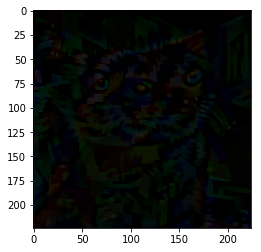

[2208.7627]


In [125]:
from IPython import display

# The training procedure goes here
loss_profile = []

for epoch_idx in range(num_steps):
    grad, loss = compute_grad(normalized_batch, recon_images, sub_model)
    recon_images = recon_images - learning_rate * grad
#     Visualize the images
    if epoch_idx % 100 == 0:
        display.clear_output(wait=True)
        display_images(recon_images.numpy())
        print(loss.numpy())
    loss_profile.append(loss.numpy())

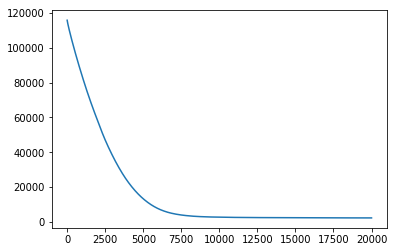

In [126]:
plt.plot(loss_profile)
plt.show()

In [127]:
!mkdir generated_images

mkdir: cannot create directory ‘generated_images’: File exists


In [0]:
from PIL import Image

# Write the reconstructed image to a file
for img_arr in recon_images.numpy():
#     Resacle the image before saving it
    img = np.zeros(shape=img_shape)
    for channel in range(3):
        img_channel = img_arr[:, :, channel]
        img[:, :, channel] = 255 * (img_channel - img_channel.min()) / (img_channel.max() - img_channel.min())
    
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    img.save(f'generated_images/img_{limiting_layer_name}.jpg')

In [0]:
# !rm -rf generated_images